# <h1> <center> Tabular Playground Series - Oct 2021</center></h1>

   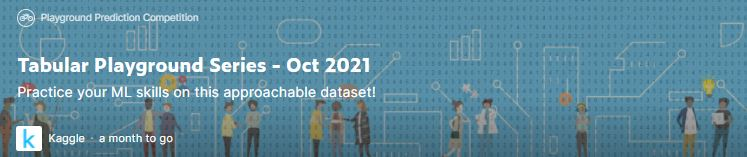

<a id="1"></a>
<h2 style='background:#1777C4; border:0; color:white'><center>Overview</center></h2>


Kaggle competitions are incredibly fun and rewarding, but they can also be intimidating for people who are relatively new in their data science journey. In the past, kaggle team have launched many Playground competitions that are more approachable than Featured competitions and thus, more beginner-friendly.
<p> 
For this competition, we will be predicting a binary target based on a number of feature columns given in the data. The columns are a mix of scaled continuous features and binary features.

<a id="1"></a>
<h2 style='background:#1777C4; border:0; color:white'><center>About the data</center></h2>

  The data consists of three files :
* train.csv - the training data with the target column
* test.csv - the test set; you will be predicting the target for each row in this file (the probability of the binary target)
* sample_submission.csv - a sample submission file in the correct format

<a id="1"></a>
<h2 style='background:#1777C4; border:0; color:white'><center> Notebook Set Up</center></h2>

In [ ]:
import os 
import torch
import numpy as np 
import pandas as pd 
import datatable as dt
import seaborn as sns 
import matplotlib.pyplot as plt # ploting
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import torch.optim as optim
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from collections import Counter
import warnings
warnings.filterwarnings('ignore')
print("Packages Imported ")

<a id="1"></a>
<h2 style='background:#1777C4; border:0; color:white'> <center> Load data</center></h2>

#### Read Data 

In [ ]:
train_data= pd.read_csv('../input/tabular-playground-series-oct-2021/train.csv')
test_data= pd.read_csv('../input/tabular-playground-series-oct-2021/test.csv')
print("Data imported")

#### Reduce memory usage

In [ ]:
# shout out to this discussion (((https://www.kaggle.com/c/tabular-playground-series-oct-2021/discussion/275854)))
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df


In [ ]:
train = reduce_mem_usage(train_data)
test = reduce_mem_usage(test_data)

<a id="1"></a>
<h2 style='background:#1777C4; border:0; color:white'> <center> Explorotary Data Analysis</center></h2>
We first take a look at our dataframes ( train and test ). after that we will establish a baseline. 
<h3> Train data First look  <h3> 

In [ ]:
train_data.head()

In [ ]:


print(f'Number of rows: {train_data.shape[0]};  Number of columns: {train_data.shape[1]}; No of missing values: {sum(train_data.isna().sum())}')

The train data has 1000000 rows , 287 columns ( we have quite a lot of features ) and no missing values 

#### dara type 

In [ ]:
Counter(train_data.info())

There 46 Boolean values , 240 float16 and one int32 

#### Basic summary statistic

In [ ]:
train_data.describe().style.background_gradient(cmap='coolwarm')

#### Features Variation

In [ ]:
# variables variaition   
df_var=train.var().reset_index()
df_var.columns =['feature', 'variation']
df_var.sort_values("variation",ascending = False)

Some features have very low variation maybe we will consider removing them.


#### Correlation matrix

In [ ]:
# Correlationmatrix
corrMatrix =train_data.corr(method='pearson', min_periods=1)
corrMatrix

#### Correlation with the target

In [ ]:
cor_targ = train.corrwith(train["target"]).reset_index()
cor_targ.columns =['feature', 'CorrelatioWithTarget']
cor_targ.sort_values('CorrelatioWithTarget',ascending = False)


#### Target variable 
The target for this Competition is binary valued, let's check the distribution of values 



In [ ]:
print('percentage of claim values:')
percent_value = pd.DataFrame(train_data['target'].value_counts()/len(train_data))
percent_value.T

In [ ]:
countplt, ax = plt.subplots(figsize = (8,5))
ax =sns.countplot(train_data['target'],palette="GnBu_r")

We have a balanced class problem.

### Test Data First look

In [ ]:
test_data.head()

In [ ]:
print(f'Number of rows: {test_data.shape[0]};  Number of columns: {test_data.shape[1]}; No of missing values: {sum(test_data.isna().sum())}')

The test data has 500000 rows , 286 columns ( what did you thought xD) and zero missing values 

In [ ]:
print('Info about test data: ')
test_data.info()


#### basic summary statistics 

In [ ]:
test_data.describe().style.background_gradient(cmap='YlOrRd')

#### Distribution of mean and std
we want to see the distribution of the mean and standard deviation values per row and column in the train and test data .

In [ ]:
plt.figure(figsize=(15,8))
features = train.columns.values[2:286]
sns.distplot(train[features].mean(axis=1),color="green", kde=True,bins=120, label='train')
sns.distplot(test[features].mean(axis=1),color="darkblue", kde=True,bins=120, label='test')
plt.title("Distribution of mean values per row in the train and test data")
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(15,5))
sns.distplot(train[features].mean(axis=0),color="orange",kde=True,bins=120, label='train')
sns.distplot(test[features].mean(axis=0),color="blue", kde=True,bins=120, label='test')
plt.title("Distribution of mean values per column in the train and test set")
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(15,5))
sns.distplot(train[features].std(axis=1),color="#2F4F4F", kde=True,bins=120, label='train')
sns.distplot(test[features].std(axis=1),color="#FF6347", kde=True,bins=120, label='test')
plt.title("Distribution of std per row in the train and test data ")
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(15,5))
sns.distplot(train[features].std(axis=0),color="#778899",kde=True,bins=120, label='train')
sns.distplot(test[features].std(axis=0),color="#800080", kde=True,bins=120, label='test')
plt.title("Distribution of std per column in the train and test data")
plt.legend()
plt.show()

#### Feature Distribution 

In [ ]:
features = train.iloc[:,1:138] # loc features 
i = 1
plt.figure()
fig, ax = plt.subplots(figsize=(28, 28))
for feature in features:
    plt.subplot(28, 5,i)
    sns.distplot(train[feature],color="blue", kde=True,bins=120, label='train')
    sns.distplot(test[feature],color="orange", kde=True,bins=120, label='test')
    i += 1
    
plt.legend()
plt.show()

In [ ]:
features = train.iloc[:,138:286] # loc features 
i = 1
plt.figure()
fig, ax = plt.subplots(figsize=(28, 28))
for feature in features:
    plt.subplot(30, 5,i)
    sns.distplot(train[feature],color="blue", kde=True,bins=120, label='train')
    sns.distplot(test[feature],color="orange", kde=True,bins=120, label='test')
    i += 1
    
plt.legend()
plt.show()

we can see that train and test features have similar distribution.


<a id="1"></a>
<h2 style='background:#1777C4; border:0; color:white'><center>TabNet : Attentive Interpretable Tabular Learning</center></h2>

For this competition we will use  pytorch-tabnet from [Dreamquark](https://github.com/dreamquark-ai/tabnet) , you can read about the original paper [Here](https://arxiv.org/pdf/1908.07442.pdf). 

Please refer to [Selfsupervised tabnet notebook](https://www.kaggle.com/optimo/selfsupervisedtabnet) if you want to learn about tabnetPretrainer. Even though this is a classification problem for this version i will treat it as a regressor problem using TabnetRegressor which appears to give more high public score ( in a typical classifaction problem you would use TabnetClassifer. Check the first five versions )  




In [ ]:
#install tabnet 
!pip install pytorch-tabnet

In [ ]:
# import tabnetmodules 
from pytorch_tabnet.pretraining import TabNetPretrainer
from pytorch_tabnet.tab_model import TabNetRegressor 

#### Data preparation 

In [ ]:
# delete unused df
del train_data
del test_data 

In [ ]:
#Data preparation 
y = train["target"]
ignore_id = 'id'
features = [ col for col in train.columns if col not in ["id","target"]]
X = train [[*features]]
test = test[[*features]]

In [ ]:
scaler = MinMaxScaler(feature_range=(-1, 1))
X_norma =  scaler.fit_transform(X)
test_norma = scaler.transform(test)

In [ ]:
X_train, X_valid, y_train, y_valid= train_test_split(X_norma, y, test_size=0.25, random_state=42)

In [ ]:
# preparing tabnet input values
#X_train  = X_train.to_numpy()  
#X_valid = X_valid.to_numpy()
y_train = y_train.to_numpy().reshape(-1, 1) 
y_valid = y_valid.to_numpy().reshape(-1,1)
# labelencoder for target when using Tabnet classifier 
#y_train= LabelEncoder().fit_transform(np.ravel(y_train))
#y_valid = LabelEncoder().fit_transform(np.ravel(y_valid))

In [ ]:
# TabNetPretrainer definition 
pretrainer = TabNetPretrainer(
    n_d=8, 
    n_a=8,
    n_steps=1,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-3),
    mask_type='entmax', 
    n_shared=1, 
    n_independent=1, 
)

In [ ]:
# fit tabnet pretrainer 
pretrainer.fit(
    X_train=X_train,
    eval_set=[X_valid],
    max_epochs=100 , patience=10,
    batch_size=1024, virtual_batch_size=64,
    num_workers=0,
    drop_last=False,
    pretraining_ratio=0.55,

)

In [ ]:
# tabnet cllassifier definition 
max_epochs = 100
Bs = 2048*10
vBs = 256*10
clf = TabNetRegressor( 
                       gamma = 1.5 ,
                       lambda_sparse=1e-2,
                       optimizer_fn=torch.optim.Adam,
                       optimizer_params=dict(lr=2e-2,weight_decay=1e-5),
                       scheduler_params={"step_size":5,
                                         "gamma":0.9},
                       scheduler_fn=torch.optim.lr_scheduler.StepLR,
                       mask_type='entmax' 
                      )

In [ ]:
# training ,validating and predicting 
clf.fit( 
        X_train=X_train, y_train=y_train,
        eval_set=[(X_valid, y_valid)],
        eval_name=['valid'],
        max_epochs=max_epochs,
        patience=10,
        batch_size=Bs, virtual_batch_size=vBs,
        num_workers=0,
        drop_last=False,
        from_unsupervised = pretrainer # loading weights from pretrainer model 
           )

##### valid mse history

In [ ]:
plt.plot(clf.history['valid_mse'])

#### Predictions 

In [ ]:
#  predictions  for the test data 
#test = test.to_numpy()
predictions =  clf.predict(test_norma)

#### Submission 

In [ ]:
sample = pd.read_csv('../input/tabular-playground-series-oct-2021/sample_submission.csv' ) # read sample submission 
predictions = pd.DataFrame(predictions) # from array to dataframe
sample['target'] = predictions
sample.to_csv('tabnet_submission.csv',index=False) # save submission
sample.head() # check submision header.


### Final thoughts
* This is just a baseline submission over which a lot of improvement can be made including model parameters tuning and using Kfold training.
* There is always need for Feature Engineering and  feature Selection in order to achieve high score.
* TabnetRegressor does better then TabnetClassifer even this is a classification problem ( diffrence of 0.8 auc score .. ) 

<div class="alert alert-info">
  <h2><center>  I hope you find this useful , Thank you 🙏 </h2></center>
</div>